# Introduction: SpaceX Landing Predictions

This notebook is a follow-up to: data collection [SpaceX API notebook](https://github.com/brittabeta/Space-X-to-Y-Data-Analysis-and-Landing-Predictions), data cleaning and EDA [EDA notebook](https://github.com/brittabeta/Space-X-to-Y-Data-Analysis-and-Landing-Predictions), along with initial model selection and feature selection [notebooks](https://github.com/brittabeta/Space-X-to-Y-Data-Analysis-and-Landing-Predictions).

The main goal is to predict landing success or failure of any given Falcon9 SpaceX flight.  This information can be used to guide contract bidding which requires knowledge of how much the mission will cost.  Expenses are largely impacted by reuse of rocket parts.  Reuse, recovery, and refurbishment of the rocket core and fairings depend upon successful landing and successful retrieval respectively.

The data used was collected from the [SpaceX REST API](https://github.com/r-spacex/SpaceX-API).  This data was then cleaned, processed, and explored using Pandas with some Microsoft Excel.  The target variable is 'Class' of landing, set to 1 for success and 0 for failure.  

Classification to the correct 'Class' with accuracy is the algorithm's goal. This data includes many categorical variables.  Of note: Several boolean features have already been transformed into 1 for True and 0 for False. Much of the numerical data is of a categorical nature (nominal and ordinal), such as 'Block' (the version of the Falcon 9).  The only continuous variable is 'PayloadMass' (the mass in kg of the mission cargo).  We have categorical inputs and a categorical output.

Models choosen include: Classification versions of four models
* Two [scikit-learn](https://scikit-learn.org/stable/index.html) models: [SVC (Support Vector Machine)](https://scikit-learn.org/stable/modules/svm.html) and [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/tree.html#tree)
* Two gradient boosting models: [XGBoostClassifier](https://github.com/dmlc/xgboost) and [LGBMClassifier](https://github.com/microsoft/LightGBM)

Gradient Boosting Models
* Theory: "...an efficient algorithm for converting relatively poor hypotheses into very good hypotheses" [Michael Kearns](https://www.cis.upenn.edu/~mkearns/papers/boostnote.pdf), a weak/poor hypothesis (weak learner) performs slightly better than random chance. "The idea is to use the weak learning method several times to get a succession of hypotheses, each one refocused on the examples that the previous ones found difficult and misclassified. … Note, however, it is not obvious at all how this can be done." [Leslie Valiant](https://amzn.to/3g4YDva).
* Algorithm Basics: 1. Loss function: optimized - 2. Weak learner: decision trees 3. Additive Model: gradient descent used to add trees [Jason Brownlee](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
* For more on [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent): "...gradient descent (also often called steepest descent) is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function...repeated steps in the opposite direction of the gradient (or approximate gradient) of the function at the current point..." Gradient: "...the direction of the gradient is the direction in which the function increases most quickly from p (point p)..."

### Outline
* Preparing data and initial imports
* Hyperparameter optimization
* Feature selection
* Summary

### Preparing Data
* Load data of SpaceX launches and landings
* Organize data for the goal at hand
* One-hot encoding 
* Scaling

### Hyperparameter Optimization
* Nested k-fold cross-validation
* Tune parameters of four models
* BayesSearchCV
* Compare model performance metrics

### Feature Selection
* Prepare data for feature selection
* SelectKBest with chi-squared 
* SelectKBest with mutual information
* Compare methods impact on performance

### Summary

In [1]:
# import modules to start

import numpy as np # linear algebra, random seed, arrays
import pandas as pd # data processing, read_csv

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline 

import warnings ## importing warnings library. 
warnings.filterwarnings('ignore') ## ignore warning

/kaggle/input/spacextoy-dataanalysis-launchprediction/SpaceX Metadata.docx
/kaggle/input/spacextoy-dataanalysis-launchprediction/spacex_correlation.csv
/kaggle/input/spacextoy-dataanalysis-launchprediction/spacex_contracts_customers_known_revenue.csv
/kaggle/input/spacextoy-dataanalysis-launchprediction/Fairing Null Handling Cleaning Adding Financial Columns.docx
/kaggle/input/spacextoy-dataanalysis-launchprediction/spacex_encoded.csv
/kaggle/input/spacextoy-dataanalysis-launchprediction/spacex_financials_raw.xlsx
/kaggle/input/spacextoy-dataanalysis-launchprediction/spacex_extra_correlation.csv
/kaggle/input/spacextoy-dataanalysis-launchprediction/Space X to Y Data Analysis and Machine Learning PeerAudienceLength (1).pdf
/kaggle/input/spacextoy-dataanalysis-launchprediction/spacex.csv
/kaggle/input/spacextoy-dataanalysis-launchprediction/spacex_financials.csv


In [2]:
# for sharing, for validation, for comparison
np.random.seed(42)
# notice random_states are set throughout 

# Preparing Data

In [3]:
# load data: read the data to a dataframe using pandas
# ensure the data loaded into a dataframe the first 5 rows
df = pd.read_csv('/kaggle/input/spacextoy-dataanalysis-launchprediction/spacex.csv')
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,ReusedCore,...,ReusedFairings,CostCoreMil,CostFairingsMil,CostOtherMil,CostKgMil,CostTotalMil,RevenueReuseMil,RevenueKgMil,RevenueTotalMil,ProfitMil
0,1,6/4/2010,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,0,0,...,0,30000000.0,6000000.0,14000000.0,42734715.88,92734715.88,62000000.0,61049594.12,123049594.1,30314878.22
1,2,5/22/2012,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,0,0,...,0,30000000.0,6000000.0,14000000.0,3675000.00,53675000.00,62000000.0,5250000.00,67250000.0,13575000.00
2,3,3/1/2013,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,0,0,...,0,30000000.0,6000000.0,14000000.0,4739000.00,54739000.00,62000000.0,6770000.00,68770000.0,14031000.00
3,4,9/29/2013,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,0,0,...,0,30000000.0,6000000.0,14000000.0,3500000.00,53500000.00,62000000.0,5000000.00,67000000.0,13500000.00
4,5,12/3/2013,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,0,0,...,0,30000000.0,6000000.0,14000000.0,22190000.00,72190000.00,62000000.0,31700000.00,93700000.0,21510000.00


In [4]:
# get a list of columns with data types to see which columns are categorical
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FlightNumber     90 non-null     int64  
 1   Date             90 non-null     object 
 2   BoosterVersion   90 non-null     object 
 3   PayloadMass      90 non-null     float64
 4   Orbit            90 non-null     object 
 5   LaunchSite       90 non-null     object 
 6   Outcome          90 non-null     object 
 7   Flights          90 non-null     int64  
 8   GridFins         90 non-null     int64  
 9   ReusedCore       90 non-null     int64  
 10  Legs             90 non-null     int64  
 11  Block            90 non-null     int64  
 12  ReusedCount      90 non-null     int64  
 13  Serial           90 non-null     object 
 14  Longitude        90 non-null     float64
 15  Latitude         90 non-null     float64
 16  Class            90 non-null     int64  
 17  Year             9

In [5]:
# categorical (object data types) = 
# ['Date', 'BoosterVersion', 'Orbit', 'LaunchSite', 'Outcome', 'Serial']
# cautious elimination some columns not needed =
# Date bc we already have year, flightnumber, ~block, redundancy of data measuring time, year came from date
# BoosterVersion bc all values are Falcon 9 
# Outcome bc the target 'Class' was created using Outcomes
categorical = ['Orbit', 'LaunchSite', 'Serial']

In [ ]:
# financial data =
# don't need in landing prediction model, and 
# these are derived from reuse columns and payload mass column
# financial = ['CostCoreMil', 'CostFairingsMil','CostOtherMil', 'CostKgMil', 'CostTotalMil', 'RevenueReuseMil','RevenueKgMil', 
#             'RevenueTotalMil', 'ProfitMil']

In [6]:
# see below: compare how these variables have essentially the same meaning
print(df['Flights'].values, "\n", df['ReusedCount'].values)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1
 1 1 2 1 2 2 1 2 1 2 2 1 1 2 2 1 1 2 1 2 2 3 1 1 2 1 1 3 2 2 3 4 1 3 4 4 3
 4 2 5 4 1 5 3 1 2 6 4 2 3 6 3 1] 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 0 1 1 1 3 1 1 2 4 3 5 4 2 3 0 0 5 5 3 5 5 3 2 4 3 3 5 3 5
 3 3 4 5 2 5 3 2 2 5 3 2 2 5 2 0]


In [7]:
# see below: compare how these variables have essentially the same meaning
NoGridFinsOutcome = df[df['GridFins'] == False].groupby('Outcome')['GridFins'].count()
NoLegsOutcome = df[df['Legs'] == False].groupby('Outcome')['Legs'].count()
print(NoGridFinsOutcome, NoLegsOutcome)

Outcome
False Ocean     2
None None      16
True Ocean      2
Name: GridFins, dtype: int64 Outcome
False Ocean     2
None None      16
True Ocean      1
Name: Legs, dtype: int64


In [8]:
# numerical (float and int data types) =
# ['FlightNumber','PayloadMass', 'Flights', 'GridFins', 'ReusedCore', 'Legs','Block', 'ReusedCount', 
# Longitude', 'Latitude', 'Class', 'Year', 'ReusedFairings']
# eliminate some columns based on EDA and metadata
## Flights and ReusedCount: pick just one, they reflect the same information
# Flights (Launch number of core/booster)
# ReusedCount (Total number flights - 1 = number of times core reused)
## Legs and GridFins: pick just one, reflect the same information
## outcomes show they both reflect intent to land in testing or core expending
# Longitude, Latitude, LaunchSite
## eliminate both long and lat, we already have LaunchSite and these are the coordinates of those launchsites

numerical = ['FlightNumber','PayloadMass', 'Flights', 'GridFins', 'ReusedCore','Block', 'Year', 'ReusedFairings']

In [9]:
# Separate out Class, the target/dependent variable
# Create y, a numpy array 
target = df['Class']
y = target.to_numpy()

In [10]:
# lets put these back together in X for features, so we have X and y, and all the relevant to landing predictions as one
X = df[numerical + categorical]
# total dataframe, add numpy array as column Class to data dataframe
data = df[numerical + categorical]
data['Class'] = y

In [11]:
# lets take a look at what we have 
X.head()
# its a dataframe of our choosen independent variables to evaluate

,FlightNumber,PayloadMass,Flights,GridFins,ReusedCore,Block,Year,ReusedFairings,Orbit,LaunchSite,Serial
0,1,6104.959412,1,0,0,1,2010,0,LEO,CCAFS SLC 40,B0003
1,2,525.000000,1,0,0,1,2012,0,LEO,CCAFS SLC 40,B0005
2,3,677.000000,1,0,0,1,2013,0,ISS,CCAFS SLC 40,B0007
3,4,500.000000,1,0,0,1,2013,0,PO,VAFB SLC 4E,B1003
4,5,3170.000000,1,0,0,1,2013,0,GTO,CCAFS SLC 40,B1004


In [12]:
# lets take a look at what we have 
y
# its an array of Class

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [13]:
# lets take a look at what we have 
data.head()
# dataframe of above and Class

,FlightNumber,PayloadMass,Flights,GridFins,ReusedCore,Block,Year,ReusedFairings,Orbit,LaunchSite,Serial,Class
0,1,6104.959412,1,0,0,1,2010,0,LEO,CCAFS SLC 40,B0003,0
1,2,525.000000,1,0,0,1,2012,0,LEO,CCAFS SLC 40,B0005,0
2,3,677.000000,1,0,0,1,2013,0,ISS,CCAFS SLC 40,B0007,0
3,4,500.000000,1,0,0,1,2013,0,PO,VAFB SLC 4E,B1003,0
4,5,3170.000000,1,0,0,1,2013,0,GTO,CCAFS SLC 40,B1004,0


In [14]:
# obtain columns in order for future reference in feature selection
data.columns

Index(['FlightNumber', 'PayloadMass', 'Flights', 'GridFins', 'ReusedCore',
       'Block', 'Year', 'ReusedFairings', 'Orbit', 'LaunchSite', 'Serial',
       'Class'],
      dtype='object')

In [15]:
# save/write to csv file to later load in feature selection
data.to_csv('fs_spacex.csv', index=False)

In [16]:
# Use get_dummies() function on the categorical columns
# one hot encoding categorical variables to obtain numerical data
X = pd.get_dummies(data=X, columns=['Orbit', 'LaunchSite', 'Serial'])
X.head()

,FlightNumber,PayloadMass,Flights,GridFins,ReusedCore,Block,Year,ReusedFairings,Orbit_ES-L1,Orbit_GEO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,6104.959412,1,0,0,1,2010,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,525.000000,1,0,0,1,2012,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,677.000000,1,0,0,1,2013,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,500.000000,1,0,0,1,2013,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,3170.000000,1,0,0,1,2013,0,0,0,...,0,0,0,0,0,0,0,0,0,0


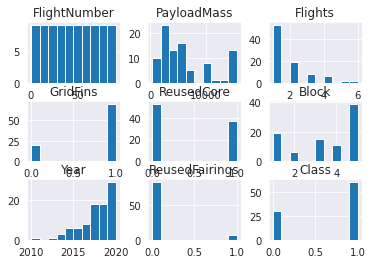

In [17]:
data.hist()
plt.show()

Scaling
* StandardScaler (standardization, mean to 0 and std to 1) or MinMaxScaler (normalization to range 0-1)
* Data does not have normal distribution, therefore we will normalize

In [18]:
# import scaling tool
from sklearn.preprocessing import MinMaxScaler
# normalize data
mms = MinMaxScaler()
X = mms.fit_transform(X)
X
# X should now be an array too

array([[0.        , 0.37737439, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01123596, 0.01147541, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02247191, 0.02144262, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.97752809, 0.98688525, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.98876404, 0.98688525, 0.4       , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.21842623, 0.        , ..., 0.        , 0.        ,
        1.        ]])

# Hyperparameter Tuning

Nested k-fold cross validation

"In order to overcome the bias in performance evaluation, model selection should be viewed as an integral part of the model fitting procedure, and should be conducted independently in each trial in order to prevent selection bias and because it reflects best practice in operational use." [Gavin C. Cawley, Nicola L. C. Talbot; 11(70):2079−2107, 2010](https://www.jmlr.org/papers/v11/cawley10a.html)

One k-fold cross-validation (for parameter selection) will be nested within another k-fold cross-validation (for model selection). An outer KFold() is called, then entire feature dataset is given to .split(), enumeration provides row indexes for each k-fold, an inner KFold() is called, the inner k-fold is passed in the search method RandomizedSearchCV (or GridSearchCV), the model with best parameters is fit to training data (retrieved with .best_estimator_), this model is then used to make predictions using the testing data, along the way scoring estimates are monitored using .best_score_ with those parameters tested. [Nested Cross-Validation for Machine Learning](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/) 

BayesSearchCV()

Scikit-optimize provides a drop-in replacement for sklearn.model_selection.GridSearchCV, which utilizes Bayesian Optimization where a predictive model referred to as “surrogate” is used to model the search space and utilized to arrive at good parameter values combination as soon as possible. [scikit-learn](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html) [documentation](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)

In [19]:
# import needed additional tools

# for search space and metrics
from numpy import mean
from numpy import std

# splitting data
from sklearn.model_selection import KFold

# parameter search method
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt import BayesSearchCV

# evaluation metric, accuracy, more detailed accuracy/precision/recall, false pos/neg 
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# models to compare
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier 

### Support Vector Machine
A support vector machine constructs a hyper-plane or set of hyper-planes in a high or infinite dimensional space, which can be used for classification, regression or other tasks...good separation is achieved by the hyper-plane that has the largest distance to the nearest training data points of any class (so-called functional margin), since in general the larger the margin the lower the generalization error of the classifier. [scikit-learn](https://scikit-learn.org/stable/modules/svm.html#svm-mathematical-formulation) 

In [20]:
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = SVC()
    # define search space
    space = {'kernel': ['linear','poly','rbf', 'sigmoid'],
             'C': np.logspace(-3, 3, 5),
             'gamma': np.logspace(-3, 3, 5),
             'random_state' : [1]
             }
    # define search
    search = BayesSearchCV(model, space, scoring='f1', cv=cv_inner, refit=True, n_iter = 50, random_state=1)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # report progress
    print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    # evaluate the model and store results
    f1 = f1_score(y_test, yhat)
# summarize the estimated performance of the model and obtain best parameters
print(('Accuracy F1-Score: %.3f (%.3f)' % (mean(f1), std(f1))), '\n',('Best parameters: =%s' % (result.best_params_)), '\n', 'Confusion Matrix [[TN, FP] [FN, TP]]', '\n', 
      confusion_matrix(y_test, yhat), '\n', classification_report(y_test, yhat))

est=0.898, cfg=OrderedDict([('C', 31.622776601683793), ('gamma', 0.03162277660168379), ('kernel', 'rbf'), ('random_state', 1)])
est=0.873, cfg=OrderedDict([('C', 1.0), ('gamma', 31.622776601683793), ('kernel', 'linear'), ('random_state', 1)])
est=0.865, cfg=OrderedDict([('C', 31.622776601683793), ('gamma', 0.03162277660168379), ('kernel', 'rbf'), ('random_state', 1)])
est=0.842, cfg=OrderedDict([('C', 1000.0), ('gamma', 31.622776601683793), ('kernel', 'poly'), ('random_state', 1)])
est=0.879, cfg=OrderedDict([('C', 1.0), ('gamma', 0.001), ('kernel', 'linear'), ('random_state', 1)])
est=0.845, cfg=OrderedDict([('C', 31.622776601683793), ('gamma', 0.03162277660168379), ('kernel', 'sigmoid'), ('random_state', 1)])
est=0.879, cfg=OrderedDict([('C', 1.0), ('gamma', 31.622776601683793), ('kernel', 'linear'), ('random_state', 1)])
est=0.885, cfg=OrderedDict([('C', 1.0), ('gamma', 31.622776601683793), ('kernel', 'linear'), ('random_state', 1)])
est=0.909, cfg=OrderedDict([('C', 1000.0), ('gamm

### Decision Tree Classifier
Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation. [scikit-learn](https://scikit-learn.org/stable/modules/tree.html#tree) An explanation of decision tree structure is available from [scikit-learn](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#) as well.

In [21]:
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = DecisionTreeClassifier()
    # define search space
    space = {'criterion': ['gini', 'entropy'],
             'splitter': ['best', 'random'],
             'max_depth': np.arange(2 ,19, 1),
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': np.arange(1, 5, 1),
             'min_samples_split': np.arange(2, 6, 1),
             'random_state' : [1]
            }
    # define search
    search = BayesSearchCV(model, space, scoring='f1', cv=cv_inner, refit=True, n_iter = 50, random_state=1)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # report progress
    print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    # evaluate the model and store results
    f1 = f1_score(y_test, yhat)
    #accuracy.append(f1)
# summarize the estimated performance of the model and obtain best parameters
print(('Accuracy F1-Score: %.3f (%.3f)' % (mean(f1), std(f1))), '\n', 
     ('Best parameters: =%s' % (result.best_params_)), '\n', 'Confusion Matrix [[TN, FP] [FN, TP]]', '\n', 
      confusion_matrix(y_test, yhat), '\n', classification_report(y_test, yhat))

est=0.870, cfg=OrderedDict([('criterion', 'entropy'), ('max_depth', 4), ('max_features', 'sqrt'), ('min_samples_leaf', 3), ('min_samples_split', 4), ('random_state', 1), ('splitter', 'random')])
est=0.851, cfg=OrderedDict([('criterion', 'entropy'), ('max_depth', 5), ('max_features', 'auto'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('random_state', 1), ('splitter', 'best')])
est=0.851, cfg=OrderedDict([('criterion', 'gini'), ('max_depth', 6), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 3), ('random_state', 1), ('splitter', 'random')])
est=0.813, cfg=OrderedDict([('criterion', 'entropy'), ('max_depth', 7), ('max_features', 'auto'), ('min_samples_leaf', 2), ('min_samples_split', 3), ('random_state', 1), ('splitter', 'best')])
est=0.846, cfg=OrderedDict([('criterion', 'gini'), ('max_depth', 3), ('max_features', 'sqrt'), ('min_samples_leaf', 3), ('min_samples_split', 3), ('random_state', 1), ('splitter', 'random')])
est=0.889, cfg=OrderedDict([('crite

### XGBoostClassifier
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. [XGBoost Documentation](https://xgboost.readthedocs.io/en/stable/index.html)

In [22]:
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = XGBClassifier()
    # define search space
    space = {'n_estimators': np.arange(50, 1000, 50),
             'eta': np.arange(0.01, 0.3, 0.01),
             'max_depth' : np.arange(1, 11, 1),
             'min_child_weight' : np.arange(1, 8, 1),
             'booster' : ['gbtree', 'dart', 'gblinear'],
             'alpha': [0, 0.1, 0.5, 1.0],
             'lambda' : np.arange(0.01, 1.1, 0.01), 
             'seed' : [1]
            }
    # define search
    search = BayesSearchCV(model, space, scoring='f1', cv=cv_inner, refit=True, n_iter = 50, random_state=1)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # report progress
    print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    # evaluate the model and store results
    f1 = f1_score(y_test, yhat)
    #accuracy.append(f1)
# summarize the estimated performance of the model and obtain best parameters
print(('Accuracy F1-Score: %.3f (%.3f)' % (mean(f1), std(f1))), '\n', 
     ('Best parameters: =%s' % (result.best_params_)), '\n', 'Confusion Matrix [[TN, FP] [FN, TP]]', '\n', 
      confusion_matrix(y_test, yhat), '\n', classification_report(y_test, yhat))

[14:44:44] WARNING: ../src/learner.cc:627: 
Parameters: { "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:44:44] WARNING: ../src/learner.cc:627: 
Parameters: { "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:44:44] WARNING: ../src/learner.cc:627: 
Parameters: { "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to

### LightGBMClassifier
LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages: faster training speed and higher efficiency, lower memory usage, better accuracy, support of parallel, distributed, and GPU learning, capable of handling large-scale data. [LightGBM’s documentation](https://lightgbm.readthedocs.io/en/latest/index.html#)

In [23]:
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = LGBMClassifier()
    # define search space
    space = {'n_estimators' : np.arange(50, 1000, 50) , 
             'learning_rate' : np.linspace(0.0001, 1.0, 10),
             'max_depth' : np.arange(1, 11, 2),
             'num_leaves' : np.arange(2, 21, 2),
             'boosting_type' : ['gbdt', 'dart', 'goss'],
             'reg_alpha' : np.arange(0, 1.1, 0.1),
             'reg_lambda' : np.arange(0, 1.1, 0.01),
             'random_state' : [1]
            }
    # define search
    search = BayesSearchCV(model, space, scoring='f1', cv=cv_inner, refit=True, n_iter = 50, random_state=1)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # report progress
    print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    # evaluate the model and store results
    f1 = f1_score(y_test, yhat)
    #accuracy.append(f1)
# summarize the estimated performance of the model and obtain best parameters
print(('Accuracy F1-Score: %.3f (%.3f)' % (mean(f1), std(f1))), '\n', 
     ('Best parameters: =%s' % (result.best_params_)), '\n', 'Confusion Matrix [[TN, FP] [FN, TP]]', '\n', 
      confusion_matrix(y_test, yhat), '\n', classification_report(y_test, yhat))

est=0.810, cfg=OrderedDict([('boosting_type', 'goss'), ('learning_rate', 0.6667000000000001), ('max_depth', 9), ('n_estimators', 250), ('num_leaves', 8), ('random_state', 1), ('reg_alpha', 0.2), ('reg_lambda', 0.39)])
est=0.799, cfg=OrderedDict([('boosting_type', 'gbdt'), ('learning_rate', 0.11120000000000001), ('max_depth', 5), ('n_estimators', 200), ('num_leaves', 10), ('random_state', 1), ('reg_alpha', 0.1), ('reg_lambda', 0.28)])
est=0.792, cfg=OrderedDict([('boosting_type', 'goss'), ('learning_rate', 0.4445), ('max_depth', 5), ('n_estimators', 250), ('num_leaves', 14), ('random_state', 1), ('reg_alpha', 0.7000000000000001), ('reg_lambda', 0.33)])
est=0.791, cfg=OrderedDict([('boosting_type', 'gbdt'), ('learning_rate', 0.4445), ('max_depth', 1), ('n_estimators', 400), ('num_leaves', 10), ('random_state', 1), ('reg_alpha', 1.0), ('reg_lambda', 0.6900000000000001)])
est=0.797, cfg=OrderedDict([('boosting_type', 'goss'), ('learning_rate', 0.0001), ('max_depth', 7), ('n_estimators', 30

* Collect results
* Visualize to aide evaluation and decisions

In [24]:
# define list of models and visualize models
models = ['SVC', 'DecisionTreeClassifier', 'XGBClassifier', 'LGBMClassifier']
# list for column of f1-score accuracy predicting landing success
f11 = [1.0,.67,.8,.73]
# list for column of f1-score accuracy predicting landing failure
f10 = [1.0,.33,.75,.57]
# f1 weighted average column taking both accuracy predicting success or failure
f1_weighted_average = [1,.56,.78,.68]
# from confusion matrix add columns related to Type I and II error
# FPR false positive rate - predicted to land, but failed = FP / FP + TN = 1 – TNR
FPR = [0,.67,0,.33]
# TNR true negative rate - specifity or selectivity
specificity = [1.0,.33,1.0,.67]
# FNR false negative rate - predicted to fail, but landed = FN/FN+TP = 1 – TPR
FNR = [0,.33,.33,.33]
# TPR true positive rate - sensitivity, recall, hit rate
sensitivity = [1.0,.67,.67,.67]
# create a data frame of results
list_tuples = list(zip(models,f11))
df_model = pd.DataFrame(list_tuples, columns = ['Model', 'F1_1'])
# add each list as a new column
df_model['F1_0'] = f10
df_model['F1_Weighted_Average'] = f1_weighted_average
df_model['FPR'] = FPR
df_model['Specificity'] = specificity
df_model['FNR'] = FNR
df_model['Sensitivity'] = sensitivity
df_model

,Model,F1_1,F1_0,F1_Weighted_Average,FPR,Specificity,FNR,Sensitivity
0,SVC,1.00,1.00,1.00,0.00,1.00,0.00,1.00
1,DecisionTreeClassifier,0.67,0.33,0.56,0.67,0.33,0.33,0.67
2,XGBClassifier,0.80,0.75,0.78,0.00,1.00,0.33,0.67
3,LGBMClassifier,0.73,0.57,0.68,0.33,0.67,0.33,0.67


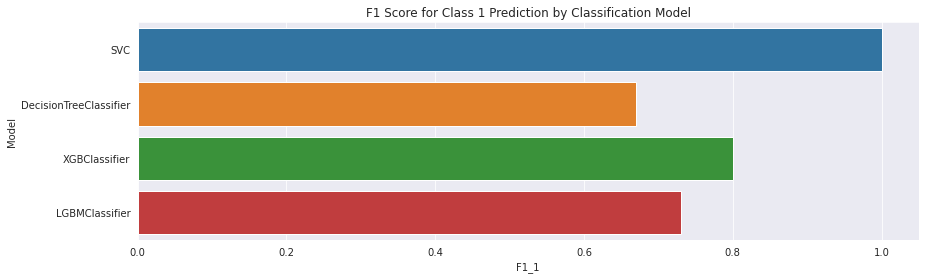

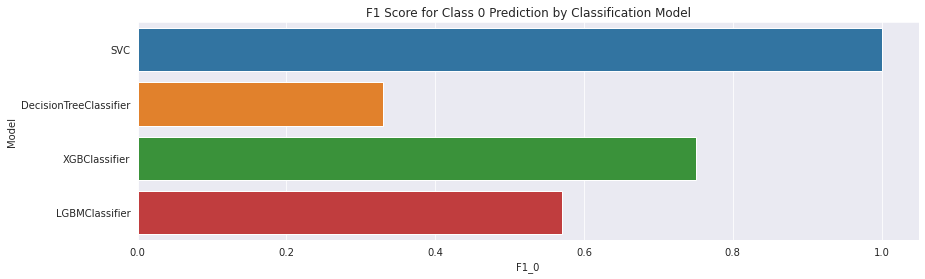

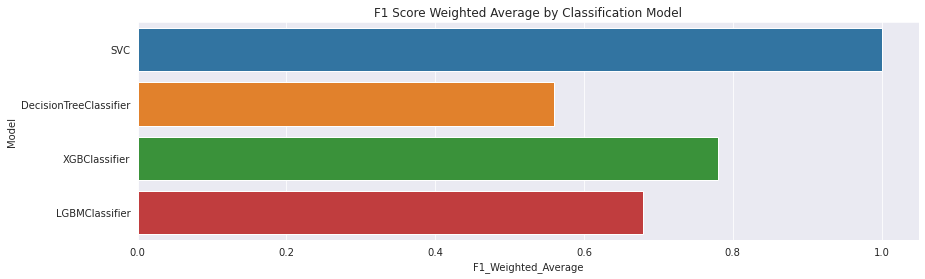

In [25]:
# Visualize the built model accuracy 
plt.figure(figsize=(14,4))
plt.title("F1 Score for Class 1 Prediction by Classification Model")
plot = sns.barplot(x='F1_1',y='Model', data=df_model)
# Visualize the built model accuracy 
plt.figure(figsize=(14,4))
plt.title("F1 Score for Class 0 Prediction by Classification Model")
plot = sns.barplot(x='F1_0',y='Model', data=df_model)
# Visualize the built model accuracy 
plt.figure(figsize=(14,4))
plt.title("F1 Score Weighted Average by Classification Model")
plot = sns.barplot(x='F1_Weighted_Average',y='Model', data=df_model)

* SVC: most accurate predicting landing success
* SVC:  most accurate predicting landing failure
* SVC: highest weighted average accuracy

(-1.0, 4.0)

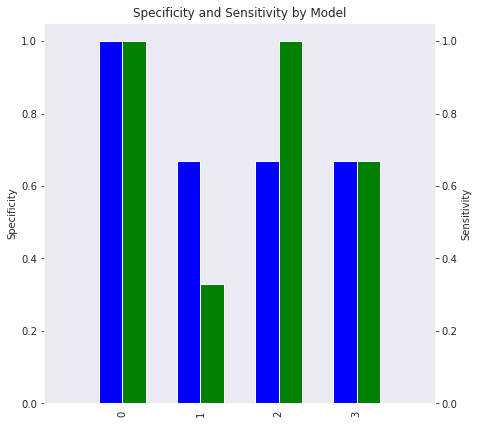

In [26]:
# visualize confusion matrix results
#df_model = df_model.set_index('Model') #set model as index
fig = plt.figure(figsize=(7,7)) #create the figure
ax = fig.add_subplot(111) # create matplotlib axes
ax2 = ax.twinx() # create another axes that shares the same x-axis
width = .3
df_model.Specificity.plot(kind='bar',color='green',ax=ax,width=width, position=0)
df_model.Sensitivity.plot(kind='bar',color='blue', ax=ax2,width = width,position=1)
plt.title('Specificity and Sensitivity by Model')
ax.grid(None)
ax2.grid(None)
ax.set_ylabel('Specificity')
ax2.set_ylabel('Sensitivity')
ax.set_xlim(-1,4)

* SVC: highest specificity
* SVC: highest sensitivity


* Note: changing parameter search spaces, iterations, k-folds, search methods could alter this result

# Feature Selection

Feature selection reduces the number of independent variables, selecting those most useful to the model, with the aim of improving performance and efficiency.  Feature selection can be unsupervised (removal of variables highly correlated with one another), or supervised (wrapper, filter, intrinsic) which used the target variable to eliminate irrelevant variables.  Wrapper use recursive feature elimination (RFE) to find subsets of independent variables.  Filter uses statistics to find subsets based on relationship to the target variable.  Intrinsic involves models that utilize feature selection during training, such as DTs.  Choosing statistics depends upon the data type of the independent variables: numerical integer, numerical float, categorical boolean, categorical ordinal, categorical nominal.  Further more, statistic choice depends upon the combination of the input and output variable datatype.

As the SpaceX data we have for feature inputs is almost exclusively categorical and the target variable is categorical, the chi-squared test (contingency tables) and mutual information (information gain) are most appropriate.  For chi-squared [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) provides sklearn.feature_selection.chi2(X, y) to compute, "chi-squared stats...score can be used to select the n_features features with the highest values for the test chi-squared statistic from X, which must contain only non-negative features." For mutual information [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) provides sklearn.feature_selection.mutual_info_classif(X, y, \*, discrete_features='auto', n_neighbors=3, copy=True, random_state=None) to estimate "Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency."  For the selection method [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) provides sklearn.feature_selection.SelectKBest(score_func=<function f_classif>, \*, k=10), which selects, "features according to the k highest scores." 

[Jason Brownlee](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)

### Chi-2 and SelectKBest

Chi-2
Determines whether the output variable is dependent or independent of the input variables.  If independent, then the variable may be irrelevant to the objective.
A statistical hypothesis test with the null hypothesis that the observed frequencies for a categorical variable match the expected frequencies for the categorical variable.
The chi-squared test calculates expected frequencies, then determines whether observed frequencies match the expected frequencies (by chance alone).  If the frequencies are sufficiently different, then the variables are deemed dependent and the null hypothesis is rejected. [Jason Brownlee](https://machinelearningmastery.com/chi-squared-test-for-machine-learning/)

In [27]:
# import preprocessing tools
from sklearn.preprocessing import LabelEncoder # string to numerical with one input
#from sklearn.preprocessing import OrdinalEncoder # string to numerical with multiple inputs
from sklearn.feature_selection import SelectKBest # perform stat scores to select features
from sklearn.feature_selection import chi2, mutual_info_classif

# load dataset
data = pd.read_csv('/kaggle/working/fs_spacex.csv', header=None)  # load the dataset as a pandas DataFrame

# Encode target labels with value between 0 and n_classes-1
data = data.apply(LabelEncoder().fit_transform)
# retrieve numpy array
dataset = data.values  
# split into input (X) and output (y) variables
X = dataset[:, :-1]
y = dataset[:,-1]

# import to split data into testing and training set
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize array dimensions
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)
# now we have arrays for all 4 sets

Train (60, 11) (60,)
Test (31, 11) (31,)


In [28]:
# feature selection preparation for SelectKBest and chi2
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all') # could set to # of features
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# feature selection: prepare prepared data
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

In [29]:
# find scores for features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 119.812624
Feature 1: 66.069949
Feature 2: 35.176692
Feature 3: 6.569029
Feature 4: 7.127820
Feature 5: 14.314762
Feature 6: 11.801548
Feature 7: 36.844612
Feature 8: 3.406955
Feature 9: 3.471596
Feature 10: 116.071380


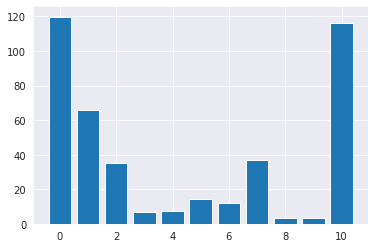

In [30]:
# note column names in order are:
# 0 FlightNumber, 1 PayloadMass, 2 Flights, 3 GridFins, 4 ReusedCore, 5 Block, 6 Year, 7 ReusedFairings, 8 Orbit, 9 LaunchSite, 10 Serial

# plot scores for features
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

* Most relevant: FlightNumber, Serial, PayloadMass, ReusedFairings, Flights
* Least relevant: Orbit, LaunchSite, GridFins, ReusedCore, Year, Block

In [40]:
# prepare using chosen features, prepare as before for fair comparison
# load dataset as pandas DataFrame
df = pd.read_csv('/kaggle/working/fs_spacex.csv')
# organize data
chi_features = ['FlightNumber', 'Serial', 'PayloadMass', 'ReusedFairings', 'Flights']
# Separate out Class and create a numpy array
target = df['Class']
y = target.to_numpy()
# lets put these back together in X for features, so we have X and y, and all the relevant to landing predictions as one
X = df[chi_features]
# Use get_dummies() function on the categorical columns
X = pd.get_dummies(data=X, columns=['Serial'])
# normalize
mms = MinMaxScaler()
# fit and transform the data, X -> numpy array now too, just like Y, arguments are to be arrays
X = mms.fit_transform(X)

In [41]:
# import requires tools
# calculations
from numpy import mean
from numpy import std
# splitting data
from sklearn.model_selection import KFold
# evaluation metric, accuracy, more detailed accuracy/precision/recall, false pos/neg 
from sklearn.metrics import f1_score, classification_report, confusion_matrix
# model
from sklearn.svm import SVC

# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = SVC(C = 1, gamma = 0.001, kernel = 'linear', random_state = 1)
    # fit model on whole training set
    result = model.fit(X_train, y_train)
    # evaluate model on the hold out dataset
    yhat = model.predict(X_test)
    # evaluate the model
    f1 = f1_score(y_test, yhat)
# summarize the estimated performance of the model and obtain best parameters
print(('Accuracy F1-Score: %.3f (%.3f)' % (mean(f1), std(f1))), '\n', 
      'Confusion Matrix [[TN, FP] [FN, TP]]', '\n', confusion_matrix(y_test, yhat), '\n', classification_report(y_test, yhat))

Accuracy F1-Score: 0.600 (0.000) 
 Confusion Matrix [[TN, FP] [FN, TP]] 
 [[2 1]
 [3 3]] 
               precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.75      0.50      0.60         6

    accuracy                           0.56         9
   macro avg       0.57      0.58      0.55         9
weighted avg       0.63      0.56      0.57         9



Results compared to using all features:
* F1 accuracy for predicting landing success: decrease 1 -> 0.60
* F1 accuracy for predincting landing failure: decrease 1 -> 0.50
* Performance was not improved eliminating chi-2 test features deemed irrelevant

### SelectKBest and Mutual Information

Mutual information
MI is information gain, reduction in entropy or quantity of information in a random variable, applied to feature (variable) selection.  MI calculates the dependence between two variables, each input and the target; this measures reduction in uncertainty for one variable.  The larger the value, the greater the relationship (dependence). [Jason Brownlee](https://machinelearningmastery.com/information-gain-and-mutual-information/)

In [42]:
# load dataset
data = pd.read_csv('/kaggle/working/fs_spacex.csv', header=None)  # load the dataset as a pandas DataFrame

# Encode target labels with value between 0 and n_classes-1
data = data.apply(LabelEncoder().fit_transform)
# retrieve numpy array
dataset = data.values  
# split into input (X) and output (y) variables
X = dataset[:, :-1]
y = dataset[:,-1]

# import to split data into testing and training set
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize array dimensions
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)
# now we have arrays for all 4 sets

Train (60, 11) (60,)
Test (31, 11) (31,)


Perform feature selection with mutual information and SelectKBest

In [43]:
# feature selection preparation for SelectKBest and mutual_info_classif
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k='all') #could set to # of features
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# feature selection: prepare prepared data
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

In [44]:
# find scores for features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 0.024606
Feature 1: 0.000000
Feature 2: 0.000000
Feature 3: 0.230595
Feature 4: 0.000000
Feature 5: 0.104315
Feature 6: 0.110931
Feature 7: 0.000000
Feature 8: 0.039978
Feature 9: 0.000000
Feature 10: 0.131467


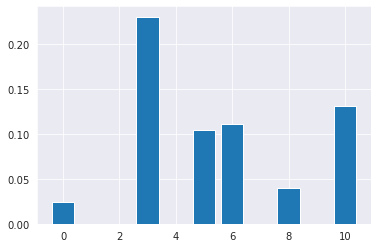

In [45]:
# note column names in order are:
# 0 FlightNumber, 1 PayloadMass, 2 Flights, 3 GridFins, 4 ReusedCore, 5 Block, 6 Year, 7 ReusedFairings, 8 Orbit, 9 LaunchSite, 10 Serial

# plot scores for features
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

* Most relevant features: GridFins, Serial, Year, Block, Orbit
* Least relevant features: PayloadMass, Flights, ReusedCore, ReusedFairings, FlightNumber

See how using them affects model performance

In [46]:
# prepare using chosen features, prepare as before for fair comparison
# load dataset as pandas DataFrame
data = pd.read_csv('/kaggle/working/fs_spacex.csv')
# organize data
mi_features = ['GridFins', 'Serial', 'Year', 'Block', 'Orbit']
# Separate out Class and create a numpy array
target = data['Class']
y = target.to_numpy()
# lets put these back together in X for features, so we have X and y, and all the relevant to landing predictions as one
X = data[mi_features]
# Use get_dummies() function on the categorical columns
X = pd.get_dummies(data=X, columns=['Serial', 'Orbit'])
# standardize features as before
from sklearn import preprocessing
# normalize
mms = MinMaxScaler()
# fit and transform the data, X -> numpy array now too, just like Y, arguments are to be arrays
X = mms.fit_transform(X)

In [47]:
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = SVC(C = 1, gamma = 0.001, kernel = 'linear', random_state = 1)
    # fit model on whole training set
    result = model.fit(X_train, y_train)
    # evaluate model on the hold out dataset
    yhat = model.predict(X_test)
    # evaluate the model
    f1 = f1_score(y_test, yhat)
# summarize the estimated performance of the model and obtain best parameters
# summarize the estimated performance of the model and obtain best parameters
print(('Accuracy F1-Score: %.3f (%.3f)' % (mean(f1), std(f1))), '\n', 
      'Confusion Matrix [[TN, FP] [FN, TP]]', '\n', confusion_matrix(y_test, yhat), '\n', classification_report(y_test, yhat))

Accuracy F1-Score: 1.000 (0.000) 
 Confusion Matrix [[TN, FP] [FN, TP]] 
 [[3 0]
 [0 6]] 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



Results compared to using all features:
* F1 accuracy for predicting landing success: increase 1.00 -> 1.00
* F1 accuracy for predincting landing failure: increase 1.00 -> 1.00
* Mutual information provides consistent performance 

Check without hyperparameters to see how MI affects performance of SVC

In [49]:
# prepare 
# load dataset as pandas DataFrame
data = pd.read_csv('/kaggle/working/fs_spacex.csv')
# organize data
all_features = ['FlightNumber', 'PayloadMass', 'Flights', 'GridFins', 'ReusedCore', 'Block', 'Year', 'ReusedFairings', 'Orbit', 'LaunchSite', 'Serial']
# Separate out Class and create a numpy array
target = data['Class']
y = target.to_numpy()
# lets put these back together in X for features, so we have X and y, and all the relevant to landing predictions as one
X = data[all_features]
# Use get_dummies() function on the categorical columns
X = pd.get_dummies(data=X, columns=['Serial', 'Orbit', 'LaunchSite'])
# standardize features as before
from sklearn import preprocessing
# normalize
mms = MinMaxScaler()
# fit and transform the data, X -> numpy array now too, just like Y, arguments are to be arrays
X = mms.fit_transform(X)

In [50]:
# performance of SVC with all features, without parameters from tuning
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = SVC()
    # fit model on whole training set
    result = model.fit(X_train, y_train)
    # evaluate model on the hold out dataset
    yhat = model.predict(X_test)
    # evaluate the model
    f1 = f1_score(y_test, yhat)
# summarize the estimated performance of the model and obtain best parameters
# summarize the estimated performance of the model and obtain best parameters
print(('Accuracy F1-Score: %.3f (%.3f)' % (mean(f1), std(f1))), '\n', 
      'Confusion Matrix [[TN, FP] [FN, TP]]', '\n', confusion_matrix(y_test, yhat), '\n', classification_report(y_test, yhat))

Accuracy F1-Score: 0.923 (0.000) 
 Confusion Matrix [[TN, FP] [FN, TP]] 
 [[2 1]
 [0 6]] 
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.86      1.00      0.92         6

    accuracy                           0.89         9
   macro avg       0.93      0.83      0.86         9
weighted avg       0.90      0.89      0.88         9



In [51]:
# prepare using chosen features, prepare as before for fair comparison
# load dataset as pandas DataFrame
data = pd.read_csv('/kaggle/working/fs_spacex.csv')
# organize data
mi_features = ['GridFins', 'Serial', 'Year', 'Block', 'Orbit']
# Separate out Class and create a numpy array
target = data['Class']
y = target.to_numpy()
# lets put these back together in X for features, so we have X and y, and all the relevant to landing predictions as one
X = data[mi_features]
# Use get_dummies() function on the categorical columns
X = pd.get_dummies(data=X, columns=['Serial', 'Orbit'])
# standardize features as before
from sklearn import preprocessing
# normalize
mms = MinMaxScaler()
# fit and transform the data, X -> numpy array now too, just like Y, arguments are to be arrays
X = mms.fit_transform(X)

In [52]:
# configure the cross-validation procedure - without parameters
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = SVC()
    # fit model on whole training set
    result = model.fit(X_train, y_train)
    # evaluate model on the hold out dataset
    yhat = model.predict(X_test)
    # evaluate the model
    f1 = f1_score(y_test, yhat)
# summarize the estimated performance of the model and obtain best parameters
# summarize the estimated performance of the model and obtain best parameters
print(('Accuracy F1-Score: %.3f (%.3f)' % (mean(f1), std(f1))), '\n', 
      'Confusion Matrix [[TN, FP] [FN, TP]]', '\n', confusion_matrix(y_test, yhat), '\n', classification_report(y_test, yhat))

Accuracy F1-Score: 1.000 (0.000) 
 Confusion Matrix [[TN, FP] [FN, TP]] 
 [[3 0]
 [0 6]] 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



Without parameters to test MI feature selection:
Results compared to using all features:
* F1 accuracy for predicting landing success: increase 0.80 -> 1.00
* F1 accuracy for predincting landing failure: increase 0.92 -> 1.00
* Mutual information provided improved performance 

### Chi-2 vs Mutual Information

* Chi-2 test did not improve SVC model performance
* Mutual information provided consistent (improved) performance

# Summary

### Hyperparameter Tuning
Support Vector Machine (SVC) with parameters C = 1.0, gamma = 0.001, kernel = linear found by BayesSearchCV performed better than the Decision Tree Classifier and both gradient boosting models.  Altering search space may alter results.  Time was a factor, BayesSearchCV is still pretty slow, but not as slow as GridSearchCV.

### Feature Selection
Using mutual information provided improved performance of the SVC model without parameters, and maintained performance with best parameters chosen in this scenario.  Chi-2 decreased classification accuracy.  The top 5 features deemed relevant to 'Class' prediction by MI were: 'GridFins', 'Serial', 'Year', 'Block', 'Orbit'

### Using Support Vector Machine (SVC) with parameters C = 1.0, gamma = 0.001, kernel = linear and 'GridFins', 'Serial', 'Year', 'Block', 'Orbit'will likely provide greatest accuracy in predicting landing success or failure and thus aide in mission bidding decisions with greater confidence